# Introduction

# Import Library

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# Import and Visulize Dataset

In [ ]:
# Read dataset
df = pd.read_csv('/kaggle/input/stockprice/UNVR.JK.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2005-01-03,665.0,670.0,665.0,670.0,398.274231,7907500
1,2005-01-04,670.0,675.0,665.0,670.0,398.274231,11352500
2,2005-01-05,665.0,670.0,665.0,670.0,398.274231,10062500
3,2005-01-06,665.0,665.0,660.0,665.0,395.302002,10942500
4,2005-01-07,665.0,665.0,660.0,665.0,395.302002,1452500


In [ ]:
# Set Date as index
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

In [ ]:
# Check dataframe shape
df.shape

(4563, 6)

In [ ]:
# Check dataframe info
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4563 entries, 2005-01-03 to 2023-06-09
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       4563 non-null   float64
 1   High       4563 non-null   float64
 2   Low        4563 non-null   float64
 3   Close      4563 non-null   float64
 4   Adj Close  4563 non-null   float64
 5   Volume     4563 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 249.5 KB


In [ ]:
# Check missing values
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

## Dataset Visualization

### High and Low

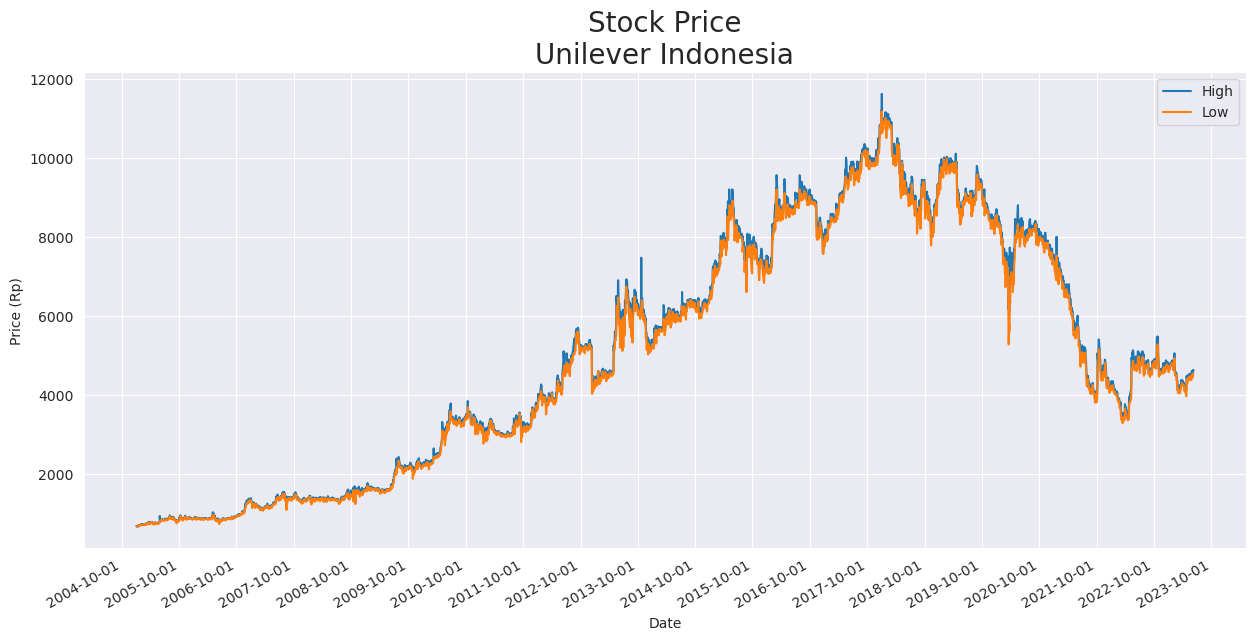

In [ ]:
sns.set_style('darkgrid')
plt.figure(figsize=(15,7))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=12))
x_dates = df.index.values

plt.plot(x_dates, df['High'], label='High')
plt.plot(x_dates, df['Low'], label='Low')
plt.xlabel('Date')
plt.ylabel('Price (Rp)')
plt.title("Stock Price\nUnilever Indonesia", fontsize=20)
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

### Open and Close

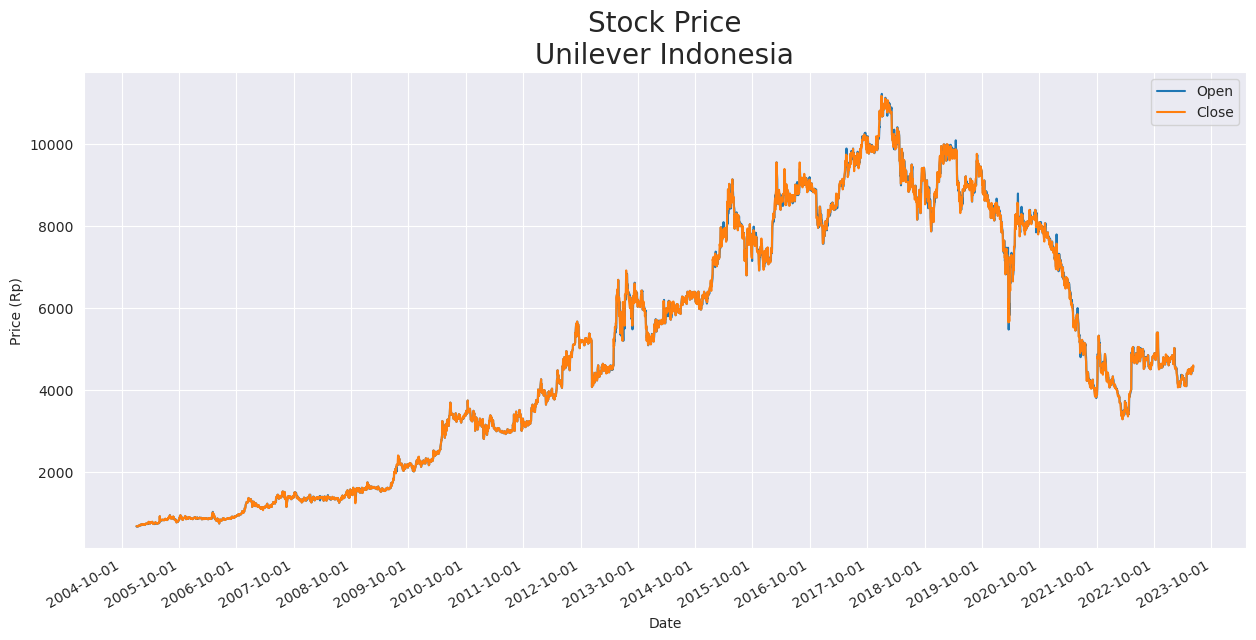

In [ ]:
plt.figure(figsize=(15,7))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=12))

plt.plot(x_dates, df['Open'], label='Open')
plt.plot(x_dates, df['Close'], label='Close')
plt.xlabel('Date')
plt.ylabel('Price (Rp)')
plt.title("Stock Price\nUnilever Indonesia", fontsize=20)
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

### Close and Adj Close

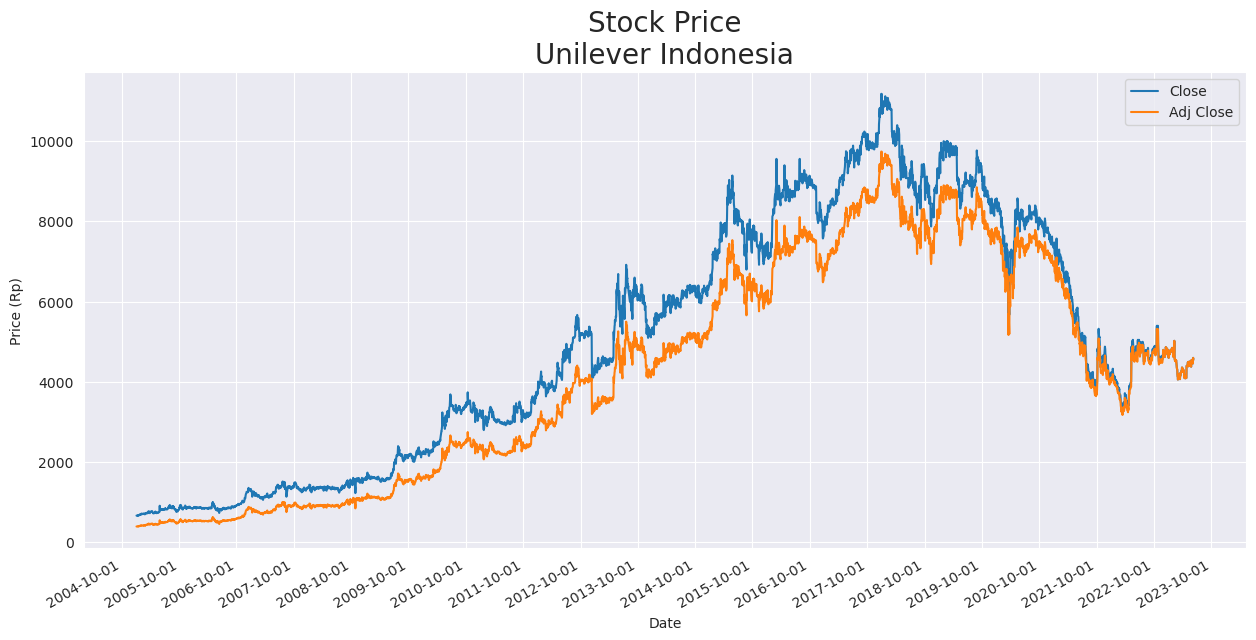

In [ ]:
plt.figure(figsize=(15,7))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=12))

plt.plot(x_dates, df['Close'], label='Close')
plt.plot(x_dates, df['Adj Close'], label='Adj Close')
plt.xlabel('Date')
plt.ylabel('Price (Rp)')
plt.title("Stock Price\nUnilever Indonesia", fontsize=20)
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

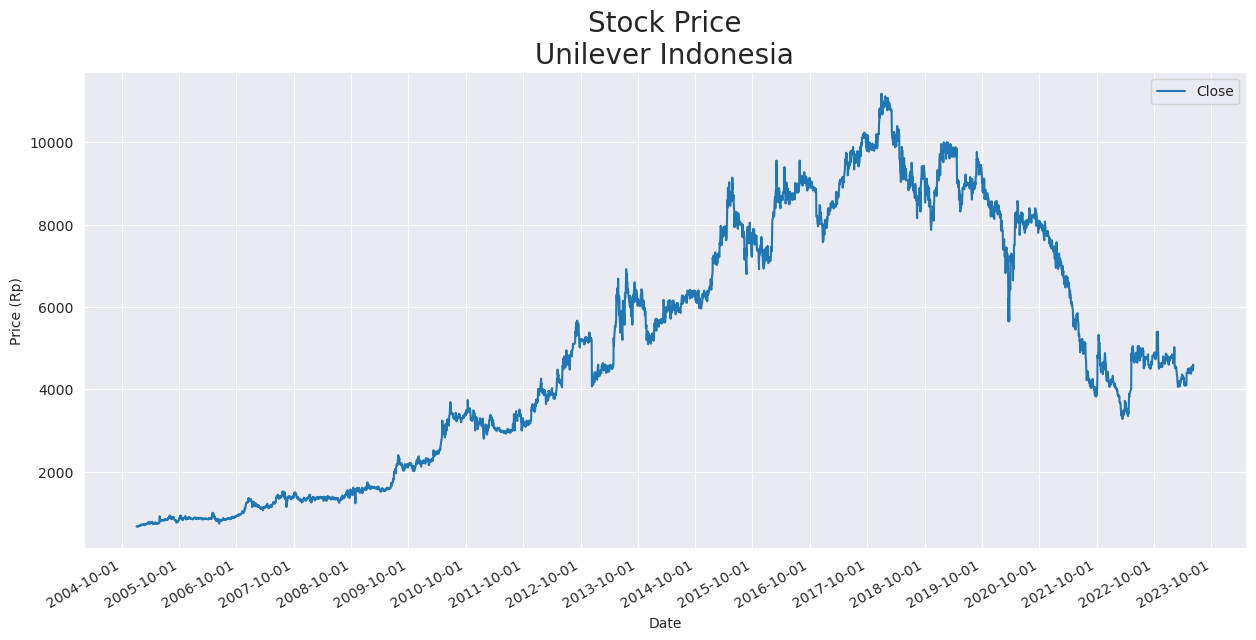

In [ ]:
plt.figure(figsize=(15,7))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=12))

plt.plot(x_dates, df['Close'], label='Close')
plt.xlabel('Date')
plt.ylabel('Price (Rp)')
plt.title("Stock Price\nUnilever Indonesia", fontsize=20)
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

# Data Preprocessing

## Feature Scaling

In [ ]:
#MinMaxScaler
ms = MinMaxScaler()
df['Close_ms'] = ms.fit_transform(df[['Close']])

## Split Data

In [ ]:
def split_data(df, train_size):
  size = int(len(df) * train_size)
  train, test = df.iloc[0:size], df.iloc[size:len(df)]
  return train, test

In [ ]:
train, test = split_data(df['Close_ms'], 0.8) #80% Train

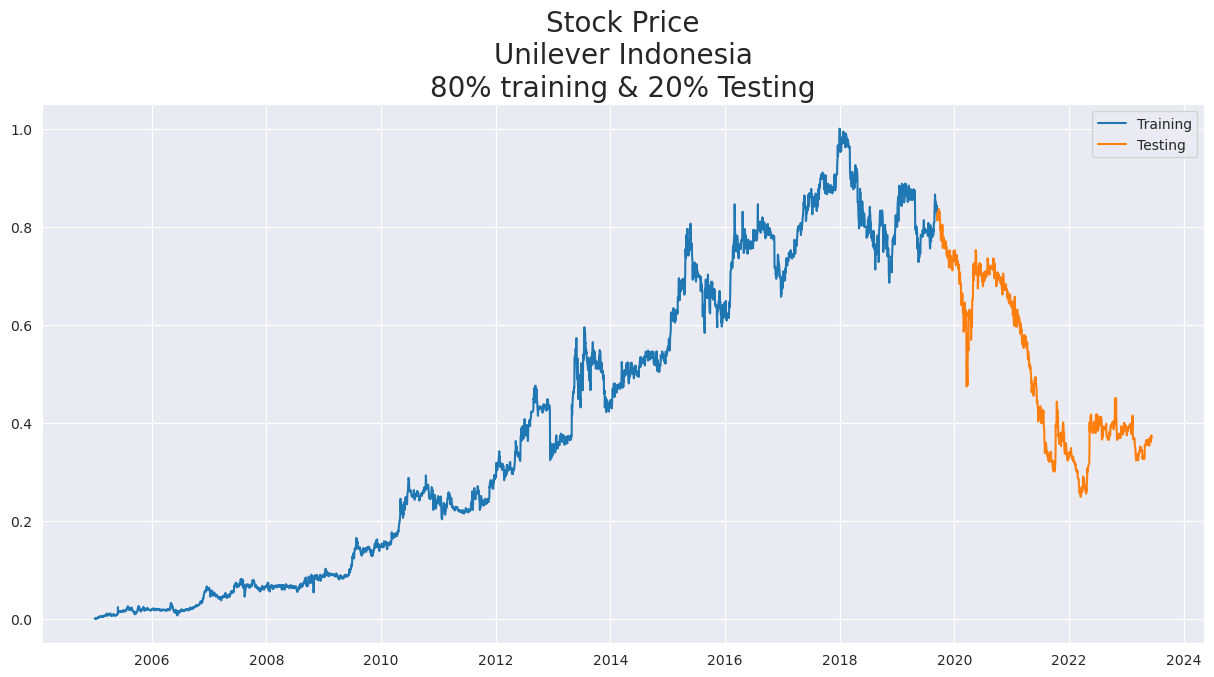

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(train)
plt.plot(test)
plt.legend(labels=['Training', 'Testing'])
plt.title('Stock Price\nUnilever Indonesia\n80% training & 20% Testing', fontsize=20)
plt.show()

In [ ]:
def split_target(df, look_back=1):
    X, y = [], []
    for i in range(len(df) - look_back):
        a = df[i:(i + look_back), 0]
        X.append(a)
        y.append(df[i + look_back, 0])
    return np.array(X), np.array(y)

In [ ]:
X_train, y_train = split_target(train.values.reshape(len(train), 1))
X_test, y_test = split_target(test.values.reshape(len(test), 1))

In [ ]:
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Build Model

In [ ]:
# Callbacks
class Callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('val_mae') is not None and logs.get('val_mae') < 0.01:
      self.model.stop_training = True

In [ ]:
model = Sequential([LSTM(128, input_shape=(1, 1), return_sequences=True),
                    Dropout(0.2),
                    LSTM(64),
                    Dropout(0.2),
                    Dense(32, activation='relu'),
                    Dense(1)])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 128)            66560     
                                                                 
 dropout (Dropout)           (None, 1, 128)            0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 118,081
Trainable params: 118,081
Non-trai

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              metrics=["mae"],
              loss=tf.keras.losses.Huber())

# Training

In [ ]:
history = model.fit(X_train,
                    y_train,
                    epochs=200,
                    batch_size=32,
                    validation_data=(X_test, y_test),
                    shuffle=False,
                    callbacks=[Callback()])

Epoch 1/200
115/115 [==============================] - 6s 14ms/step - loss: 0.0614 - mae: 0.2769 - val_loss: 0.0307 - val_mae: 0.2052
Epoch 2/200
115/115 [==============================] - 1s 6ms/step - loss: 0.0289 - mae: 0.2088 - val_loss: 0.0074 - val_mae: 0.1039
Epoch 3/200
115/115 [==============================] - 1s 6ms/step - loss: 0.0240 - mae: 0.1967 - val_loss: 0.0055 - val_mae: 0.0961
Epoch 4/200
115/115 [==============================] - 1s 6ms/step - loss: 0.0215 - mae: 0.1821 - val_loss: 0.0050 - val_mae: 0.0867
Epoch 5/200
115/115 [==============================] - 1s 6ms/step - loss: 0.0167 - mae: 0.1579 - val_loss: 0.0041 - val_mae: 0.0754
Epoch 6/200
115/115 [==============================] - 1s 6ms/step - loss: 0.0118 - mae: 0.1303 - val_loss: 0.0030 - val_mae: 0.0639
Epoch 7/200
115/115 [==============================] - 1s 6ms/step - loss: 0.0077 - mae: 0.1029 - val_loss: 0.0017 - val_mae: 0.0487
Epoch 8/200
115/115 [==============================] - 1s 6ms/step -

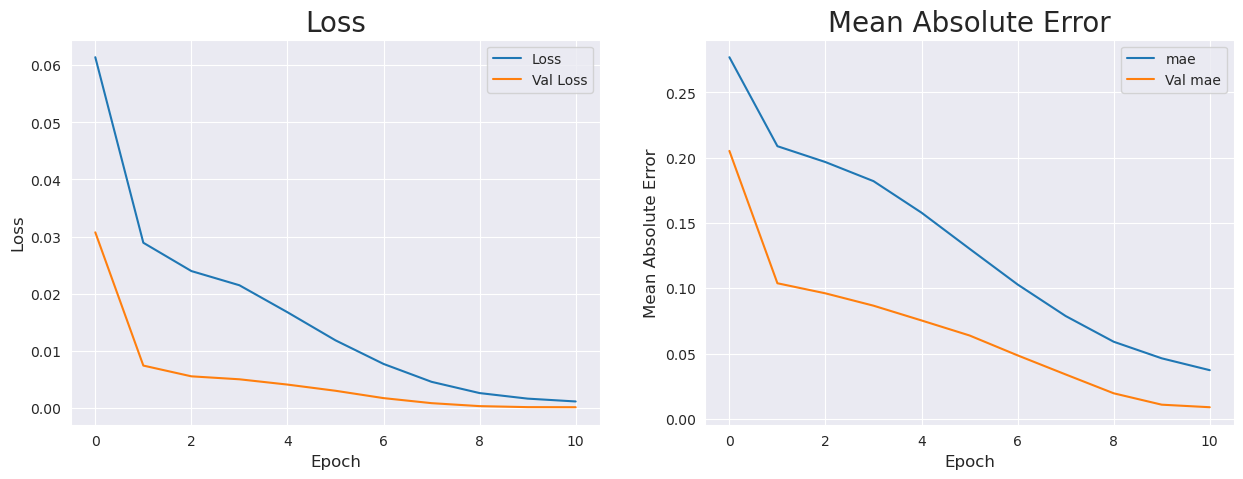

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

# Loss
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['Loss','Val Loss'])
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Loss', fontsize=20)

# MAE
ax2.plot(history.history['mae'])
ax2.plot(history.history['val_mae'])
ax2.legend(['mae','Val mae'])
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Mean Absolute Error', fontsize=12)
ax2.set_title('Mean Absolute Error', fontsize=20)
plt.show()

# Predict

29/29 [==============================] - 1s 2ms/step


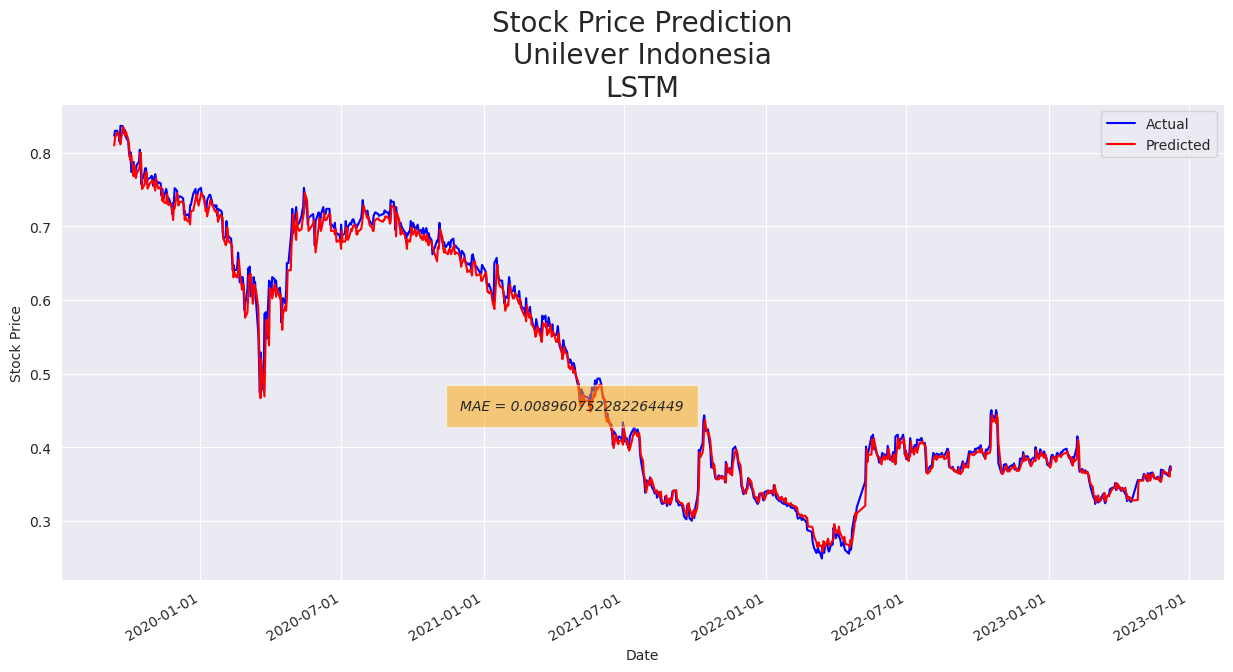

In [ ]:
# Perform prediction on the test data
pred = model.predict(X_test)
y_pred = np.array(pred).reshape(-1)

# Plot the actual and predicted prices
plt.figure(figsize=(15, 7))
plt.plot(test.index[:-1], y_test, color='blue', label='Actual')  # Exclude the last element to match the length
plt.plot(test.index[:-1], y_pred, color='red', label='Predicted')  # Exclude the last element to match the length
plt.text(test.index[300], 0.45, f"MAE = {mean_absolute_error(y_test, y_pred)}", style='italic', bbox={
        'facecolor': 'orange', 'alpha': 0.5, 'pad': 10})
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction\nUnilever Indonesia\nLSTM', fontsize=20)
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()
plt.legend()
plt.show()

## Evaluation

In [ ]:
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mape = mean_absolute_percentage_error(y_test, y_pred)
print('MAE: ', mae)
print('RSME: ', rmse)
print('MAPE: ', mape)

MAE:  0.008960752282264449
RSME:  0.012929452282302365
MAPE:  0.01839643243171354


# Plot all data with predicted result

/opt/conda/lib/python3.10/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


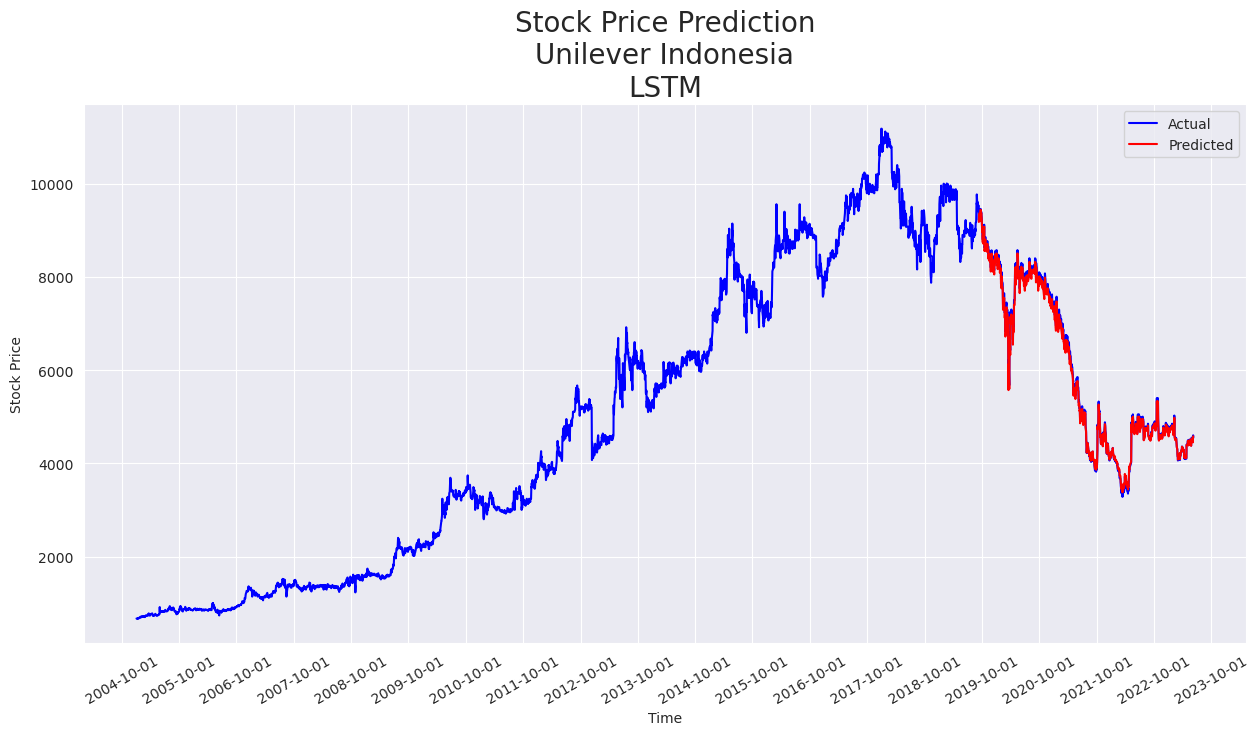

In [ ]:
# Inverse transform the predicted values
y_pred_original = ms.inverse_transform(np.array(y_pred).reshape(-1, 1))

# Plot the actual and predicted prices
plt.figure(figsize=(15, 7))
plt.plot(df.index, df['Close'], color='blue', label='Actual')
plt.plot(df.index[:-1], [None] * len(train.index) + list(y_pred_original), color='red', label='Predicted')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction\nUnilever Indonesia\nLSTM', fontsize=20)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=12))
# Rotate x-axis labels
plt.xticks(rotation=30)

plt.legend()
plt.show()